<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content-dl/blob/W2D5T1_feedbacks/tutorials/W2D5_GenerativeModels/W2D5_Tutorial1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial 1: Generative models: Variational Autoencoders (VAEs)

**Week 2, Day 5: Generative Models**

**By Neuromatch Academy**

__Content creators:__ Spiros Chavlis

__Production editors:__ Spiros Chavlis 

*Taken from UPenn course with slide modifications*:
__Instructor:__ Konrad Kording, __Original Content creators:__ Richard Lange, Arash Ash

**ALERT**: for prepod use only.

---
## Tutorial Objectives
In the first tutorial of the *Generative Models* day, we are going to

- Think about unsupervised learning and get a bird's eye view of why it is useful
- See the connection between AutoEncoding and dimensionality reduction
- Start thinking about neural networks as generative models
- Put on our Bayesian hats and turn AEs into VAEs

In [1]:
#@markdown Tutorial slides
# you should link the slides for all tutorial videos here (we will store pdfs on osf)

from IPython.display import HTML
HTML('<iframe src="https://docs.google.com/presentation/d/1_Nsq8OHIpls5iPlbA0WF53J1Ypqp02BGBGVj0zgec3c/embed?start=false&loop=false&delayms=3000" title: Tutorials" frameborder="0" width="960" height="569" allowfullscreen="true" mozallowfullscreen="true" webkitallowfullscreen="true"></iframe>')

---
# Setup

In [2]:
# we need to first upgrade the Colab's TorchVision
!pip install --upgrade torchvision --quiet

In [3]:
# imports
import torch
import random
import numpy as np
import torch.nn as nn
import torchvision as tv
import matplotlib.pylab as plt
import torch.nn.functional as F

from tqdm.notebook import tqdm, trange
from torch.utils.data import DataLoader

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
# @title Figure Settings
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", module='matplotlib')


fig_w, fig_h = (8, 6)
plt.rcParams.update({'figure.figsize': (fig_w, fig_h)})

plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

In [5]:
#@title Helper functions

def image_moments(image_batches, n_batches=None):
  """
  Compute mean an covariance of all pixels from batches of images
  """
  m1, m2 = torch.zeros((), device=DEVICE), torch.zeros((), device=DEVICE)
  n = 0
  for im in tqdm(image_batches, total=n_batches, leave=False,
                 desc='Computing pixel mean and covariance...'):
    im = im.to(DEVICE)
    b = im.size()[0]
    im = im.view(b, -1)
    m1 = m1 + im.sum(dim=0)
    m2 = m2 + (im.view(b,-1,1) * im.view(b,1,-1)).sum(dim=0)
    n += b
  m1, m2 = m1/n, m2/n
  cov = m2 - m1.view(-1,1)*m1.view(1,-1)
  return m1.cpu(), cov.cpu()


def pca_encoder_decoder(mu, cov, k):
  """
  Compute encoder and decoder matrices for PCA dimensionality reduction
  """
  mu = mu.view(1,-1)
  u, s, v = torch.svd_lowrank(cov, q=k)
  W_encode = v / torch.sqrt(s)
  W_decode = u * torch.sqrt(s)

  def pca_encode(x):
    # Encoder: subtract mean image and project onto top K eigenvectors of
    # the data covariance
    return (x.view(-1,mu.numel()) - mu) @ W_encode

  def pca_decode(h):
    # Decoder: un-project then add back in the mean
    return (h @ W_decode.T) + mu

  return pca_encode, pca_decode


def cout(x, layer):
  """Unnecessarily complicated but complete way to
  calculate the output depth, height and width size for a Conv2D layer

  Args:
      x (tuple): input size (depth, height, width)
      layer (nn.Conv2d): the Conv2D layer
  
  returns:
      (int): output shape as given in [Ref]
  
  Ref:
      https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
  """
  assert isinstance(layer, nn.Conv2d)
  p = layer.padding if isinstance(layer.padding, tuple) else (layer.padding,)
  k = layer.kernel_size if isinstance(layer.kernel_size, tuple) else (layer.kernel_size,)
  d = layer.dilation if isinstance(layer.dilation, tuple) else (layer.dilation,)
  s = layer.stride if isinstance(layer.stride, tuple) else (layer.stride,)
  in_depth, in_height, in_width = x
  out_depth = layer.out_channels
  out_height = 1 + (in_height + 2 * p[0] - (k[0] - 1) * d[0] - 1) // s[0]
  out_width = 1 + (in_width + 2 * p[-1] - (k[-1] - 1) * d[-1] - 1) // s[-1]
  return (out_depth, out_height, out_width)


In [6]:
#@title Plotting functions

def plot_linear_ae(lin_losses):
  plt.figure()
  plt.plot(lin_losses)
  plt.ylim([0, 2*torch.as_tensor(lin_losses).median()])
  plt.xlabel('Training batch')
  plt.ylabel('MSE Loss')
  plt.show()


def plot_conv_ae(lin_losses, conv_losses):
  plt.figure()
  plt.plot(lin_losses)
  plt.plot(conv_losses)
  plt.legend(['Lin AE', 'Conv AE'])
  plt.xlabel('Training batch')
  plt.ylabel('MSE Loss')
  plt.ylim([0,
            2*max(torch.as_tensor(conv_losses).median(),
                  torch.as_tensor(lin_losses).median())])
  plt.show()


def plot_images(images, h=5, w=5):
  plt.figure(figsize=(h*2, w*2))
  for i in range(h*w):
    plt.subplot(h, w, i + 1)
    plot_torch_image(images[i])
  plt.show()


def plot_phi(phi, num=4):
  plt.figure(figsize=(12, 3))
  for i in range(num):
    plt.subplot(1, num, i + 1)
    plt.scatter(zs[i, :, 0], zs[i, :, 1], marker='.')
    th = torch.linspace(0, 6.28318, 100)
    x, y = torch.cos(th), torch.sin(th)
    # Draw 2-sigma contours
    plt.plot(
        2*x*phi[i, 2].exp().item() + phi[i, 0].item(),
        2*y*phi[i, 2].exp().item() + phi[i, 1].item()
        )
    plt.xlim(-5, 5)
    plt.ylim(-5, 5)
    plt.grid()
    plt.axis('equal')
  plt.suptitle('If rsample() is correct, then most but not all points should lie in the circles')
  plt.show()


def plot_torch_image(image, ax=None):
  ax = ax if ax is not None else plt.gca()
  c, h, w = image.size()
  if c==1:
    cm = 'gray'
  else:
    cm = None

  # Torch images have shape (channels, height, width) but matplotlib expects
  # (height, width, channels) or just (height,width) when grayscale
  im_plt = torch.clip(image.detach().cpu().permute(1,2,0).squeeze(), 0.0, 1.0)
  ax.imshow(im_plt, cmap=cm)
  ax.set_xticks([])
  ax.set_yticks([])
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)

In [7]:
# @title Set seed for reproducibility in Pytorch
# https://pytorch.org/docs/stable/notes/randomness.html

def set_seed(seed):
  """
  Set random seed for reproducibility

  Args:
    seed: integer
      A positive integer to ensure reproducibility
  """
  random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.cuda.manual_seed(seed)
  np.random.seed(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

  print(f'Seed {seed} has been set.')


def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

set_seed(522)

Seed 522 has been set.


---
# Section 1: Generative models

**Note:** Please run the cell after the video to download MNIST and CIFAR10 image datasets while the video plays.

Video available at https://youtu.be/p-XT6vLjPQo


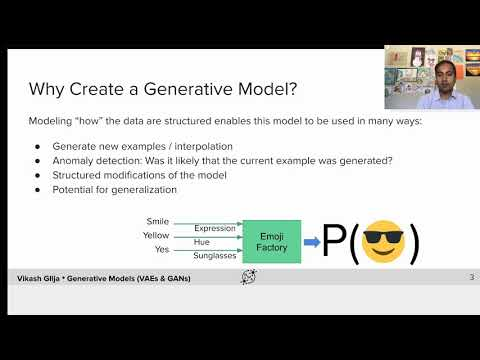

In [8]:
#@title Video 1: Generative vs. Discriminative Models
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="p-XT6vLjPQo", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

In [9]:
# @markdown Download MNIST and CIFAR10 image datasets while the above video plays
# See https://pytorch.org/docs/stable/torchvision/datasets.html
%%capture

# MNIST contains handwritten digets 0-9, in grayscale images of size (1,28,28)
mnist = tv.datasets.MNIST('./mnist/',
                          train=True,
                          transform=tv.transforms.ToTensor(),
                          download=True)
mnist_val = tv.datasets.MNIST('./mnist/',
                              train=False,
                              transform=tv.transforms.ToTensor(),
                              download=True)

cifar10 = tv.datasets.CIFAR10('./cifar10/',
                              train=True,
                              transform=tv.transforms.ToTensor(),
                              download=True)

cifar10_val = tv.datasets.CIFAR10('./cifar10/',
                                  train=False,
                                  transform=tv.transforms.ToTensor(),
                                  download=True)

## Select a dataset

We've built today's tutorial to be flexible. It should work more-or-less out of the box with both MNIST and CIFAR (and other image datasets). MNIST is in many ways simpler, and the results will likely look better and run a bit faster if using MNIST. But we are leaving it up to you to pick which one you want to experiment with!

We encourage pods to coordinate so that some members use MNIST and others use CIFAR10. Keep in mind that the CIFAR dataset may require more learning epochs. 

In [10]:
# # Default is MNIST
my_dataset = mnist
my_dataset_name = "MNIST"
my_dataset_size = (1, 28, 28)
my_dataset_dim = 28 * 28
my_valset = mnist_val

# # Uncomments for CIFAR10
# my_dataset = cifar10
# my_dataset_name = "CIFAR10"
# my_dataset_size = (3, 32, 32)
# my_dataset_dim = 3 * 32 * 32
# my_valset = cifar10_val

---
# Section 2: AutoEncoders
## Conceptual introduction to AutoEncoders

Video available at https://youtu.be/ACH27i-B-LM


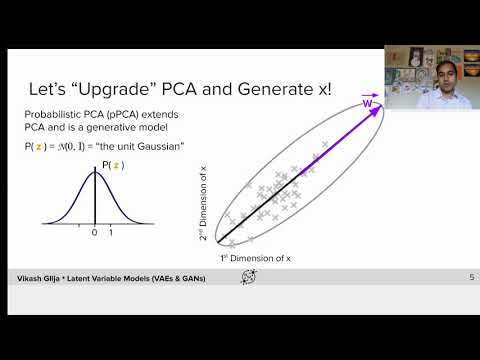

In [11]:
#@title Video 2: Latent Variable Models
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="ACH27i-B-LM", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

## Build a linear AutoEncoder

Now we'll create our first autoencoder. It will reduce images down to $K$ dimensions. The architecture will be quite simple: the input will be linearly mapped to a single hidden layer with $K$ units, which will then be linearly mapped back to an output that is the same size as the input:
$$\mathbf{x} \longrightarrow \mathbf{h} \longrightarrow \mathbf{x'}$$

The loss function we'll use will simply be mean squared error (MSE) quantifying how well the reconstruction ($\mathbf{x'}$) matches the original image ($\mathbf{x}$):
$$\text{MSE Loss} = \sum_{i=1}^{N} ||\mathbf{x}_i - \mathbf{x'}_i||^2_2$$

If all goes well, then the AutoEncoder will learn, **end to end**, a good "encoding" or "compression" of inputs ($\mathbf{x \longrightarrow h}$) as well as a good "decoding" ($\mathbf{h \longrightarrow x'}$).

The first choice to make is the dimensionality of $\mathbf{h}$. We'll see more on this below, but For MNIST, 5 to 20 is plenty. For CIFAR, we need more like 50 to 100 dimensions.

Coordinate with your pod to try a variety of values for $K$ in each dataset so you can compare results.

### Coding Exercise 2.1

Complete the missing parts of the `LinearAutoEncoder` class.

The `LinearAutoEncoder` as two stages: an `encoder` which linearly maps from inputs of size `x_dim = my_dataset_dim` to a hidden layer of size `h_dim = K` (with no nonlinearity), and a `decoder` which maps back from `K` up to the number of pixels in each image.

In [12]:
#@markdown #### Run to define the `train_autoencoder` function.
#@markdown Feel free to inspect the training function if the time allows.
def train_autoencoder(autoencoder, dataset, epochs=20, batch_size=250):
  autoencoder.to(DEVICE)
  optim = torch.optim.Adam(autoencoder.parameters(), lr=1e-3, weight_decay=1e-5)
  loss_fn = nn.MSELoss()
  g = torch.Generator()
  g.manual_seed(2021)
  loader = DataLoader(dataset, batch_size=batch_size, shuffle=True,
                      pin_memory=True, num_workers=2,
                      worker_init_fn=seed_worker,
                      generator=g)
  mse_loss = torch.zeros(epochs * len(dataset) // batch_size, device=DEVICE)
  i = 0
  for epoch in trange(epochs, desc='Epoch'):
    for im_batch, _ in loader:
      im_batch = im_batch.to(DEVICE)
      optim.zero_grad()
      reconstruction = autoencoder(im_batch)
      # write the loss calculation
      loss = loss_fn(reconstruction.view(batch_size, -1),
                     target=im_batch.view(batch_size, -1))
      loss.backward()
      optim.step()

      mse_loss[i] = loss.detach()
      i += 1
  # After training completes, make sure the model is on CPU so we can easily
  # do more visualizations and demos.
  autoencoder.to('cpu')
  return mse_loss.cpu()

In [13]:
class LinearAutoEncoder(nn.Module):
  def __init__(self, x_dim, h_dim):
    """A Linear AutoEncoder

    Args:
      x_dim (int): input dimension
      h_dim (int): hidden dimension, bottleneck dimension, K
    """
    super().__init__()
    ####################################################################
    # Fill in all missing code below (...),
    # then remove or comment the line below to test your class
    raise NotImplementedError("Please complete the LinearAutoEncoder class!")
    ####################################################################
    # encoder layer
    self.enc_lin = ...
    # decoder layer
    self.dec_lin = ...

  def encode(self, x):
    ####################################################################
    # Fill in all missing code below (...),
    raise NotImplementedError("Please complete the `encode` function!")
    ####################################################################
    h = self.enc_lin(x)
    return h

  def decode(self, h):
    ####################################################################
    # Fill in all missing code below (...),
    raise NotImplementedError("Please complete the `decode` function!")
    ####################################################################
    x_prime = self.dec_lin(h)
    return x_prime

  def forward(self, x):
    flat_x = x.view(x.size(0), -1)
    h = self.encode(flat_x)
    return self.decode(h).view(x.size())


# # Uncomment to test your code
# # Pick your own K
# K = 20
# set_seed(2021)
# lin_ae = LinearAutoEncoder(my_dataset_dim, K)
# lin_losses = train_autoencoder(lin_ae, my_dataset)
# plot_linear_ae(lin_losses)

Seed 2021 has been set.


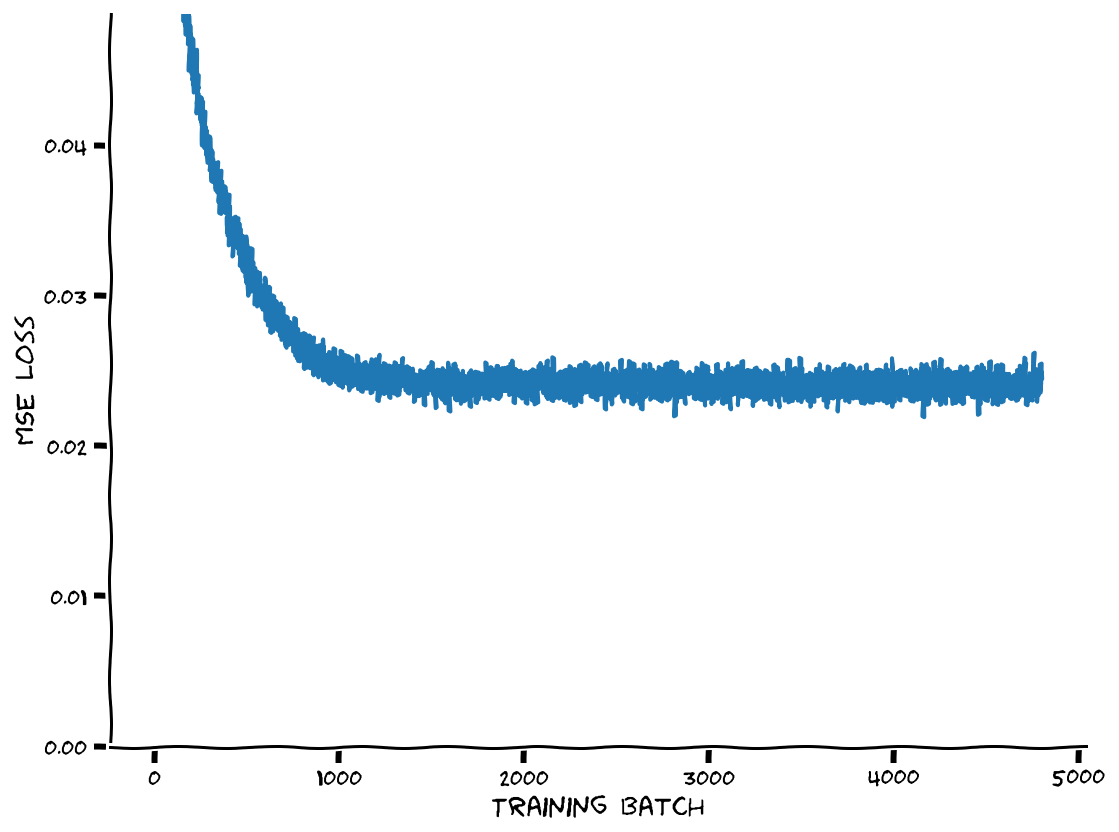

In [14]:
# to_remove solution
class LinearAutoEncoder(nn.Module):
  def __init__(self, x_dim, h_dim):
    """A Linear AutoEncoder

    Args:
      x_dim (int): input dimension
      h_dim (int): hidden dimension, bottleneck dimension, K
    """
    super().__init__()
    # encoder layer
    self.enc_lin = nn.Linear(x_dim, h_dim)
    # decoder layer
    self.dec_lin = nn.Linear(h_dim, x_dim)

  def encode(self, x):
    h = self.enc_lin(x)
    return h

  def decode(self, h):
    x_prime = self.dec_lin(h)
    return x_prime

  def forward(self, x):
    flat_x = x.view(x.size(0), -1)
    h = self.encode(flat_x)
    return self.decode(h).view(x.size())


# # Uncomment to test your code
# # Pick your own K
K = 20
set_seed(2021)
lin_ae = LinearAutoEncoder(my_dataset_dim, K)
lin_losses = train_autoencoder(lin_ae, my_dataset)
with plt.xkcd():
  plot_linear_ae(lin_losses)

One way to think about AutoEncoders is that they automatically discover good dimensionality-reduction of the data. Another easy and common technique for dimensionality reduction is to project data onto the top $K$ **principal components** (Principal Component Analysis or PCA). For comparison, let's also do PCA.

In [15]:
# PCA requires finding the top K eigenvectors of the data covariance. Start by
# finding the mean and covariance of the pixels in our dataset
g = torch.Generator()
g.manual_seed(2021)

loader = DataLoader(my_dataset,
                    batch_size=32,
                    pin_memory=True,
                    worker_init_fn=seed_worker,
                    generator=g)

mu, cov = image_moments((im for im, _ in loader),
                        n_batches=len(my_dataset) // 32)

pca_encode, pca_decode = pca_encoder_decoder(mu, cov, K)

Let's visualize some of the reconstructions ($\mathbf{x'}$) side-by-side with the input images ($\mathbf{x}$).

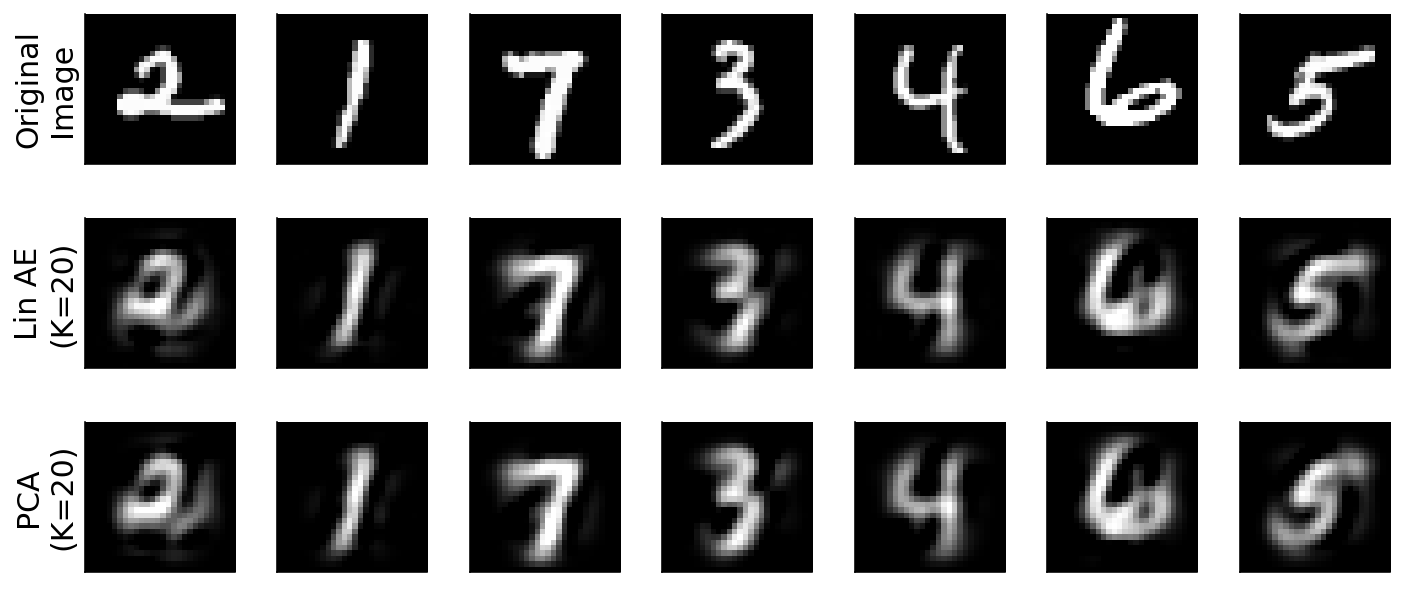

In [16]:
#@markdown Visualize the reconstructions `x'`

n_plot = 7
plt.figure(figsize=(10, 4.5))
for i in range(n_plot):
  idx = torch.randint(len(my_dataset), size=())
  image, _ = my_dataset[idx]
  # Get reconstructed image from autoencoder
  with torch.no_grad():
    reconstruction = lin_ae(image.unsqueeze(0)).reshape(image.size())

  # Get reconstruction from PCA dimensionality reduction
  h_pca = pca_encode(image)
  recon_pca = pca_decode(h_pca).reshape(image.size())

  plt.subplot(3, n_plot, i + 1)
  plot_torch_image(image)
  if i == 0:
    plt.ylabel('Original\nImage')

  plt.subplot(3, n_plot, i + 1 + n_plot)
  plot_torch_image(reconstruction)
  if i == 0:
    plt.ylabel(f'Lin AE\n(K={K})')

  plt.subplot(3, n_plot, i + 1 + 2*n_plot)
  plot_torch_image(recon_pca)
  if i == 0:
    plt.ylabel(f'PCA\n(K={K})')
plt.show()

### Think!

Compare the PCA-based reconstructions to those from the linear autoencoder. Is one better than the other? Are they equally good? Equally bad?

## Building a nonlinear convolutional autoencoder

Video available at https://youtube.com/watch?v=ZckJ-Wnx5vw


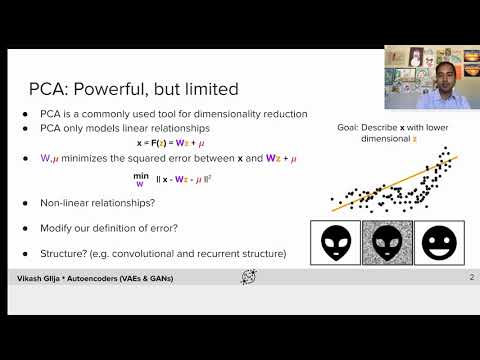

In [17]:
#@title Video 3: Autoencoders
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="ZckJ-Wnx5vw", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

The `nn.Linear` layer by default has a "bias" term, which is a learnable offset parameter separate for each output unit. Just like the PCA encoder "centered" the data by subtracting off the average image (`mu`) before encoding and added it back in during decoding, a bias term in the decoder can effectively account for the first moment of the data (AKA the average of all images in the training set). Convolution layers do have bias parameters, but the bias is applied per filter rather than per pixel location. If we're generating RGB images, then `Conv2d` will learn only 3 biases: one for each of R, G, and B.

For some conceptual continuity with both PCA and the `nn.Linear` layers above, the next block defines a custom layer for adding a learnable per-pixel offset. This custom layer will be used twice: as the first stage of the encoder and as the final stage of the decoder. Ideally, this means that the rest of the neural net can focus on fitting more interesting fine-grained structure.

In [18]:
class BiasLayer(nn.Module):
  def __init__(self, shape):
    super(BiasLayer, self).__init__()
    init_bias = torch.zeros(shape)
    self.bias = nn.Parameter(init_bias, requires_grad=True)

  def forward(self, x):
    return x + self.bias

With that out of the way, we will next define a **nonlinear** and **convolutional** autoencoder. Here's a quick tour of the architecture:

1. The **encoder** once again maps from images to $\mathbf{h}\in\mathbb{R}^K$. This will use a `BiasLayer` followed by two convolutional layers (`nn.Conv2D`), followed by flattening and linearly projecting down to $K$ dimensions. The convolutional layers will have `ReLU` nonlinearities on their outputs. 
1. The **decoder** inverts this process, taking in vectors of length $K$ and outputting images. Roughly speaking, its architecture is a "mirror image" of the encoder: the first decoder layer is linear, followed by two **deconvolution** layers ([`ConvTranspose2d`](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html)). The `ConvTranspose2d`layers will have `ReLU` nonlinearities on their _inputs_. This "mirror image" between the encoder and decoder is a useful and near-ubiquitous convention. The idea is that the decoder can then learn to approximately invert the encoder, but it is not a strict requirement (and it does not guarantee the decoder will be an exact inverse of the encoder!).

Below is a schematic of the architecture for MNIST. Notice that the width and height dimensions of the image planes reduce after each `nn.Conv2d` and increase after each `nn.ConvTranspose2d`. With CIFAR10, the architecture is the same but the exact sizes will differ a bit.

<img src="https://raw.githubusercontent.com/CIS-522/course-content/main/tutorials/W08_AutoEncoders_GANs/static/conv_sizes.png" />


[`torch.nn.ConvTranspose2d`](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html) module can be seen as the gradient of `Conv2d` with respect to its input. It is also known as a fractionally-strided convolution or a deconvolution (although it is not an actual deconvolution operation). The following code demonstrates this change in sizes:

In [19]:
dummy_image = torch.rand(my_dataset_size).unsqueeze(0)
in_channels = my_dataset_size[0]
out_channels = 7

dummy_conv = nn.Conv2d(in_channels=in_channels,
                       out_channels=out_channels,
                       kernel_size=5)

dummy_deconv = nn.ConvTranspose2d(in_channels=out_channels,
                                  out_channels=in_channels,
                                  kernel_size=5)

print(f'Size of image is {dummy_image.shape}')
print(f'Size of Conv2D(image) {dummy_conv(dummy_image).shape}')
print(f'Size of ConvTranspose2D(Conv2D(image)) {dummy_deconv(dummy_conv(dummy_image)).shape}')

Size of image is torch.Size([1, 1, 28, 28])
Size of Conv2D(image) torch.Size([1, 7, 24, 24])
Size of ConvTranspose2D(Conv2D(image)) torch.Size([1, 1, 28, 28])


### Coding Exercise 2.2: Fill in code for the `ConvAutoEncoder` module

Complete the `ConvAutoEncoder` class. We use the helper function `cout(torch.Tensor, nn.Conv2D)` to calculate the output shape of a [`nn.Conv2D`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) layer given a tensor with shape (channels, height, width).

In [20]:
class ConvAutoEncoder(nn.Module):
  def __init__(self, x_dim, h_dim, n_filters=32, filter_size=5):
    """A Convolutional AutoEncoder

    Args:
      x_dim (tuple): input dimensions (channels, height, widths)
      h_dim (int): hidden dimension, bottleneck dimension, K
      n_filters (int): number of filters (number of output channels)
      filter_size (int): kernel size
    """
    super().__init__()
    channels, height, widths = x_dim

    # encoder input bias layer
    self.enc_bias = BiasLayer(x_dim)

    # first encoder conv2d layer
    self.enc_conv_1 = nn.Conv2d(channels, n_filters, filter_size)

    # output shape of the first encoder conv2d layer given x_dim input
    conv_1_shape = cout(x_dim, self.enc_conv_1)

    # second encoder conv2d layer
    self.enc_conv_2 = nn.Conv2d(n_filters, n_filters, filter_size)

    # output shape of the second encoder conv2d layer given conv_1_shape input
    conv_2_shape = cout(conv_1_shape, self.enc_conv_2)

    # The bottleneck is a dense layer, therefore we need a flattenning layer
    self.enc_flatten = nn.Flatten()
    
    # conv output shape is (depth, height, width), so the flatten size is:
    flat_after_conv = conv_2_shape[0] * conv_2_shape[1] * conv_2_shape[2]

    # encoder Linear layer
    self.enc_lin = nn.Linear(flat_after_conv, h_dim)

    ####################################################################
    # Fill in all missing code below (...),
    # then remove or comment the line below to test your class
    # Remember that decoder is "undo"-ing what the encoder has done!
    raise NotImplementedError("Please complete the `ConvAutoEncoder` class!")
    ####################################################################
    # decoder Linear layer
    self.dec_lin = ...

    # unflatten data to (depth, height, width) shape
    self.dec_unflatten = nn.Unflatten(dim=-1, unflattened_size=conv_2_shape)

    # first "deconvolution" layer
    self.dec_deconv_1 = nn.ConvTranspose2d(n_filters, n_filters, filter_size)

    # second "deconvolution" layer
    self.dec_deconv_2 = ...

    # decoder output bias layer
    self.dec_bias = BiasLayer(x_dim)

  def encode(self, x):
    s = self.enc_bias(x)
    s = F.relu(self.enc_conv_1(s))
    s = F.relu(self.enc_conv_2(s))
    s = self.enc_flatten(s)
    h = self.enc_lin(s)
    return h

  def decode(self, h):
    s = F.relu(self.dec_lin(h))
    s = self.dec_unflatten(s)
    s = F.relu(self.dec_deconv_1(s))
    s = self.dec_deconv_2(s)
    x_prime = self.dec_bias(s)
    return x_prime

  def forward(self, x):
    return self.decode(self.encode(x))


# # Uncomment to test your solution
# K = 20
# set_seed(2021)
# conv_ae = ConvAutoEncoder(my_dataset_size, K)
# assert conv_ae.encode(my_dataset[0][0].unsqueeze(0)).numel() == K, "Encoder output size should be K!"
# conv_losses = train_autoencoder(conv_ae, my_dataset)
# plot_conv_ae(lin_losses, conv_losses)

Seed 2021 has been set.


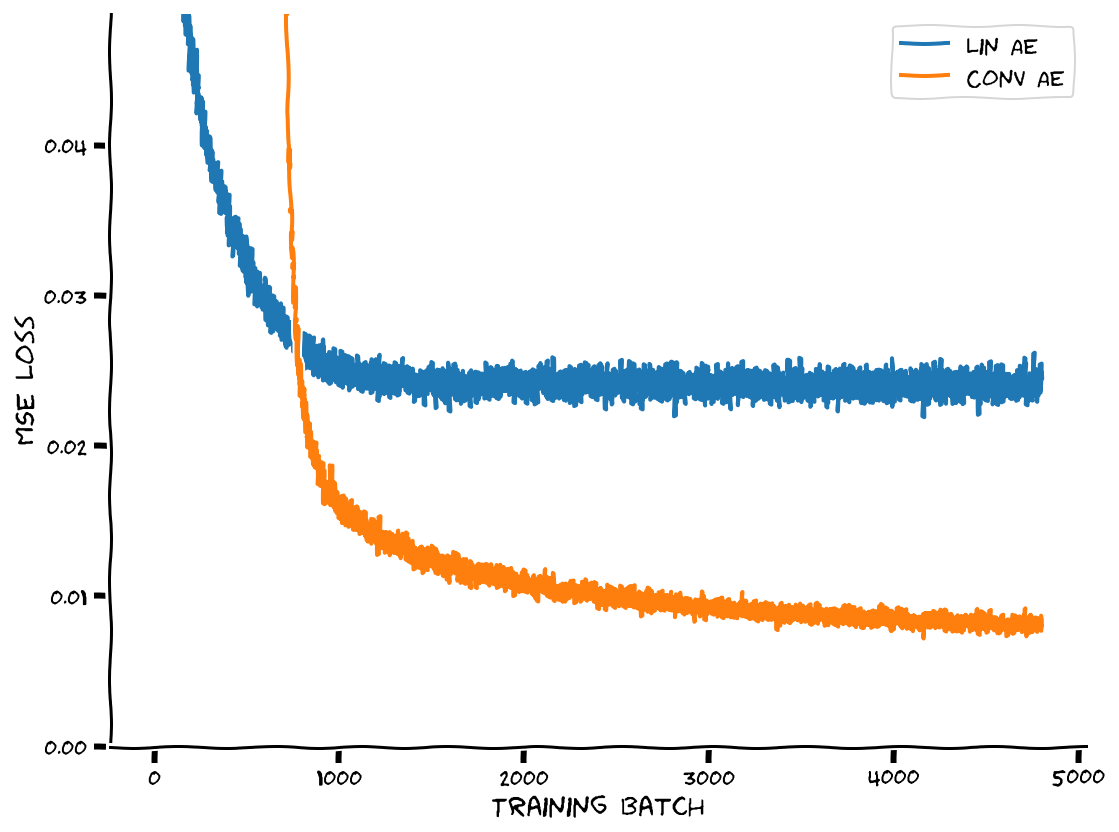

In [21]:
# to_remove solution
class ConvAutoEncoder(nn.Module):
  def __init__(self, x_dim, h_dim, n_filters=32, filter_size=5):
    """A Convolutional AutoEncoder

    Args:
      x_dim (tuple): input dimensions (channels, height, widths)
      h_dim (int): hidden dimension, bottleneck dimension, K
      n_filters (int): number of filters (number of output channels)
      filter_size (int): kernel size
    """
    super().__init__()
    channels, height, widths = x_dim

    # encoder input bias layer
    self.enc_bias = BiasLayer(x_dim)

    # first encoder conv2d layer
    self.enc_conv_1 = nn.Conv2d(channels, n_filters, filter_size)

    # output shape of the first encoder conv2d layer given x_dim input
    conv_1_shape = cout(x_dim, self.enc_conv_1)

    # second encoder conv2d layer
    self.enc_conv_2 = nn.Conv2d(n_filters, n_filters, filter_size)

    # output shape of the second encoder conv2d layer given conv_1_shape input
    conv_2_shape = cout(conv_1_shape, self.enc_conv_2)

    # The bottleneck is a dense layer, therefore we need a flattenning layer
    self.enc_flatten = nn.Flatten()
    
    # conv output shape is (depth, height, width), so the flatten size is:
    flat_after_conv = conv_2_shape[0] * conv_2_shape[1] * conv_2_shape[2]

    # encoder Linear layer
    self.enc_lin = nn.Linear(flat_after_conv, h_dim)

    # decoder Linear layer
    self.dec_lin = nn.Linear(h_dim, flat_after_conv)

    # unflatten data to (depth, height, width) shape
    self.dec_unflatten = nn.Unflatten(dim=-1, unflattened_size=conv_2_shape)

    # first "deconvolution" layer
    self.dec_deconv_1 = nn.ConvTranspose2d(n_filters, n_filters, filter_size)

    # second "deconvolution" layer
    self.dec_deconv_2 = nn.ConvTranspose2d(n_filters, channels, filter_size)

    # decoder output bias layer
    self.dec_bias = BiasLayer(x_dim)

  def encode(self, x):
    s = self.enc_bias(x)
    s = F.relu(self.enc_conv_1(s))
    s = F.relu(self.enc_conv_2(s))
    s = self.enc_flatten(s)
    h = self.enc_lin(s)
    return h

  def decode(self, h):
    s = F.relu(self.dec_lin(h))
    s = self.dec_unflatten(s)
    s = F.relu(self.dec_deconv_1(s))
    s = self.dec_deconv_2(s)
    x_prime = self.dec_bias(s)
    return x_prime

  def forward(self, x):
    return self.decode(self.encode(x))


# # Uncomment to test your solution
K = 20
set_seed(2021)
conv_ae = ConvAutoEncoder(my_dataset_size, K)
assert conv_ae.encode(my_dataset[0][0].unsqueeze(0)).numel() == K, "Encoder output size should be K!"
conv_losses = train_autoencoder(conv_ae, my_dataset)
with plt.xkcd():
  plot_conv_ae(lin_losses, conv_losses)

You should see that the `ConvAutoEncoder` achieved lower MSE loss than the linear one. If not, you may need to retrain it (or run another few training epochs from where it left off). We make fewer guarantees on this working with CIFAR10, but it should definitely work with MNIST.

Now let's visually compare the reconstructed images from the linear and nonlinear autoencoders. Keep in mind that both have the same dimensionality for $\mathbf{h}$!

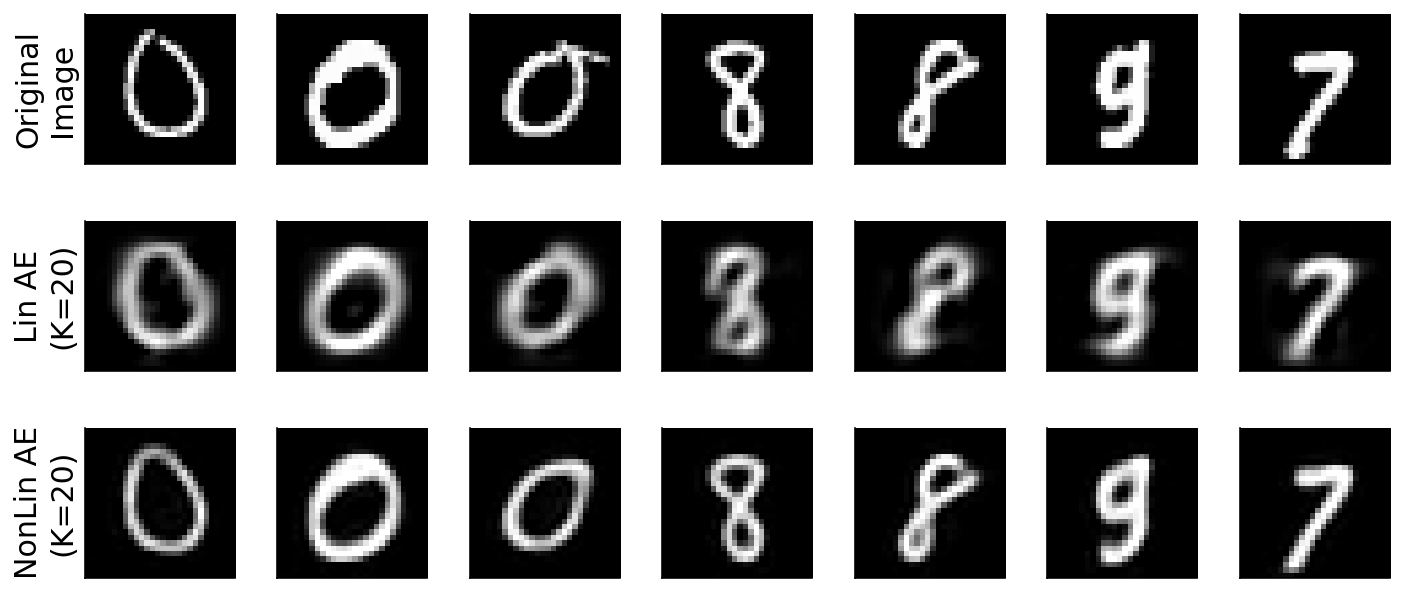

In [22]:
#@markdown Visualize the linear and nonlinear AE outputs
n_plot = 7
plt.figure(figsize=(10, 4.5))
for i in range(n_plot):
  idx = torch.randint(len(my_dataset), size=())
  image, _ = my_dataset[idx]
  with torch.no_grad():
    # Get reconstructed image from linear autoencoder
    lin_recon = lin_ae(image.unsqueeze(0))[0]

    # Get reconstruction from deep (nonlinear) autoencoder
    nonlin_recon = conv_ae(image.unsqueeze(0))[0]

  plt.subplot(3, n_plot, i+1)
  plot_torch_image(image)
  if i == 0:
    plt.ylabel('Original\nImage')

  plt.subplot(3, n_plot, i + 1 + n_plot)
  plot_torch_image(lin_recon)
  if i == 0:
    plt.ylabel(f'Lin AE\n(K={K})')

  plt.subplot(3, n_plot, i + 1 + 2*n_plot)
  plot_torch_image(nonlin_recon)
  if i == 0:
    plt.ylabel(f'NonLin AE\n(K={K})')
plt.show()

## Inspecting the hidden representations

Let's start by plotting points in the hidden space ($\mathbf{h}$), colored by class of the image (which, of course, the autoencoder didn't know about during training!)

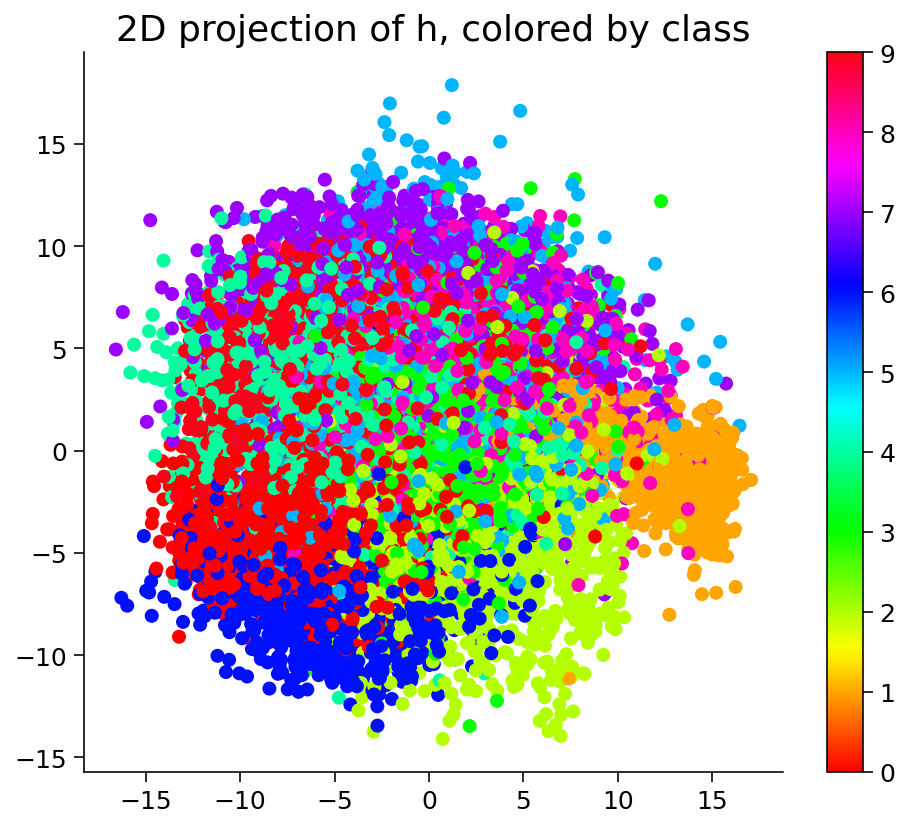

In [23]:
h_vectors = torch.zeros(len(my_valset), K, device=DEVICE)
labels = torch.zeros(len(my_valset), dtype=torch.int32)
g = torch.Generator()
g.manual_seed(2021)
loader = DataLoader(my_valset, batch_size=200,
                    pin_memory=True,
                    worker_init_fn=seed_worker,
                    generator=g)
conv_ae.to(DEVICE)
i = 0
for im, la in loader:
  b = im.size()[0]
  h_vectors[i:i+b, :] = conv_ae.encode(im.to(DEVICE))
  labels[i:i+b] = la
  i += b
conv_ae.to('cpu')
h_vectors = h_vectors.detach().cpu()
_, _, h_pcs = torch.pca_lowrank(h_vectors, q=2)
h_xy = h_vectors @ h_pcs


plt.figure(figsize=(7, 6))
plt.scatter(h_xy[:, 0], h_xy[:, 1], c=labels, cmap='hsv')
plt.title('2D projection of h, colored by class')
plt.colorbar()
plt.show()

To explore the hidden representations, $\mathbf{h}$, we're going to pick two random images from the dataset and interpolate them 3 different ways. Let's introduce some notation for this: we'll use a variable $t \in [0,1]$ to gradually transition from image $\mathbf{x}_1$ at $t=0$ to image $\mathbf{x}_2$ at $t=1$. Using $\mathbf{x}(t)$ to denote the interpolated output, the three methods will be

1. interpolate the raw pixels, so $$\mathbf{x}(t) = (1-t) \cdot \mathbf{x}_1 + t \cdot \mathbf{x}_2$$
2. interpolate their encodings from the **linear** AE, so $$\mathbf{x}(t) = \text{linear_decoder}((1-t) \cdot \text{linear_encoder}(\mathbf{x}_1) + t \cdot  \text{linear_encoder}(\mathbf{x}_2))$$
3. interpolate their encodings from the **nonlinear** AE, so $$\mathbf{x}(t) = \text{conv_decoder}((1-t) \cdot \text{conv_encoder}(\mathbf{x}_1) + t \cdot  \text{conv_encoder}(\mathbf{x}_2))$$

Note: this demo will likely look better using MNIST than using CIFAR. Check with other members of your pod. If you're using CIFAR for this notebook, consider having someone using MNIST share their screen. 

What do you notice about the "interpolated" images, especially around $t \approx 1/2$? How many distinct classes do you see in the bottom row?
Re-run the above cell a few times to look at multiple examples.

**Discuss with your pod and describe what is happening here.**

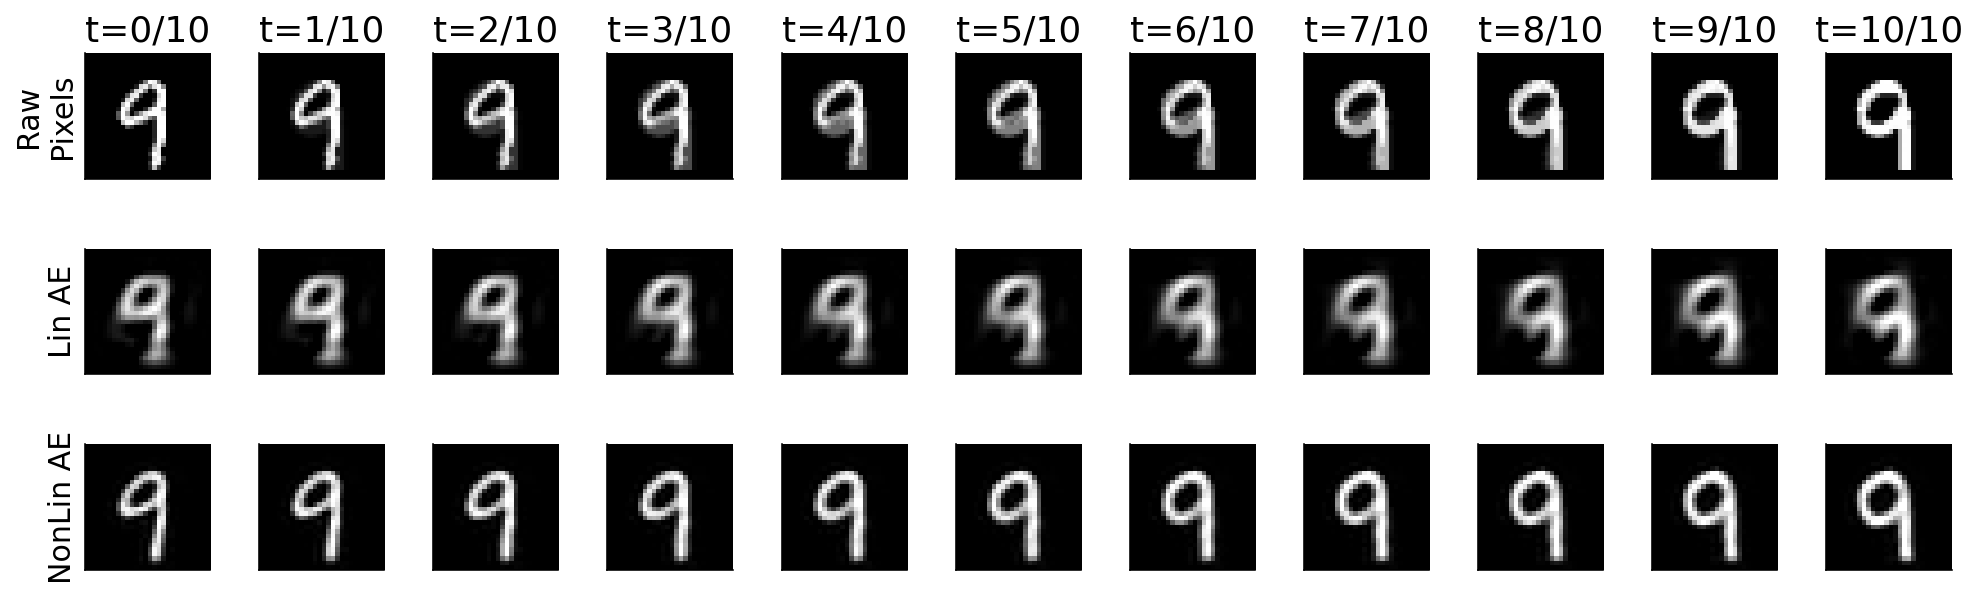

In [24]:
idx1 = torch.randint(len(my_dataset), size=())
idx2 = torch.randint(len(my_dataset), size=())
x1, _ = my_dataset[idx1]
x2, _ = my_dataset[idx2]
n_interp = 11

with torch.no_grad():
  h1_lin = lin_ae.encode(x1.reshape(1, -1))
  h2_lin = lin_ae.encode(x2.reshape(1, -1))
  h1_conv = conv_ae.encode(x1.unsqueeze(0))
  h2_conv = conv_ae.encode(x2.unsqueeze(0))

plt.figure(figsize=(14, 4.5))
for i in range(n_interp):
  t = i / (n_interp - 1)
  pixel_interp = (1 - t)*x1 + t*x2
  plt.subplot(3, n_interp, i + 1)
  plot_torch_image(pixel_interp)
  if i == 0:
    plt.ylabel('Raw\nPixels')
  plt.title(f't={i}/{n_interp-1}')

  with torch.no_grad():
    lin_ae_interp = lin_ae.decode((1-t)*h1_lin + t*h2_lin)
  plt.subplot(3, n_interp, i + 1 + n_interp)
  plot_torch_image(lin_ae_interp.reshape(my_dataset_size))
  if i == 0:
    plt.ylabel('Lin AE')

  with torch.no_grad():
    conv_ae_interp = conv_ae.decode((1-t)*h1_conv + t*h2_conv)[0]
  plt.subplot(3, n_interp, i + 1 + 2*n_interp)
  plot_torch_image(conv_ae_interp)
  if i == 0:
    plt.ylabel('NonLin AE')
plt.show()

---
# Section 3: Generative models and density networks

## Generating novel images from the decoder

If we isolate the decoder part of the AutoEncoder, what we have is a neural network that takes as input a vector of size $K$ and produces as output an image that looks something like our training data. Recall that in our earlier notation, we had an input $\mathbf{x}$ that was mapped to a low-dimensional hidden representation $\mathbf{h}$ which was then decoded into a reconstruction of the input, $\mathbf{x'}$:
$$\mathbf{x} \overset{\text{encode}}{\longrightarrow} \mathbf{h} \overset{\text{decode}}{\longrightarrow} \mathbf{x'}\, .$$
Partly as a matter of convention, and partly to distinguish where we are going next from the previous section, we're going to introduce a new variable, $\mathbf{z} \in \mathbb{R}^K$, which will take the place of $\mathbf{h}$. The key difference is that while $\mathbf{h}$ is produced by the encoder for a particular $\mathbf{x}$, $\mathbf{z}$ will be drawn out of thin air from a prior of our choosing:
$$\mathbf{z} \sim p(\mathbf{z})\\ \mathbf{z} \overset{\text{decode}}{\longrightarrow} \mathbf{x}\, .$$
(Note that it is also conventional to drop the "prime" on $\mathbf{x}$ when it is no longer being thought of as a "reconstruction").

### Coding Exercise 3.1: sample $\mathbf{z}$ from a standard normal and visualize the images produced

In [25]:
def generate_images(autoencoder, K, n_images=1):
  """Generate n_images 'new' images from the decoder part of the given
  autoencoder.

  returns (n_images, channels, height, width) tensor of images
  """
  # Concatenate tuples to get (n_images, channels, height, width)
  output_shape = (n_images,) + my_dataset_size
  with torch.no_grad():
    ####################################################################
    # Fill in all missing code below (...),
    # then remove or comment the line below to test your function
    raise NotImplementedError("Please complete the generate_images function!")
    ####################################################################
    # sample z, pass through autoencoder.decode(), and reshape output.
    z = ...
    x = ...

    return x


# # Uncomment to run it
# K = 20
# set_seed(2021)
# images = generate_images(conv_ae, K, n_images=25)
# plot_images(images)

Seed 2021 has been set.


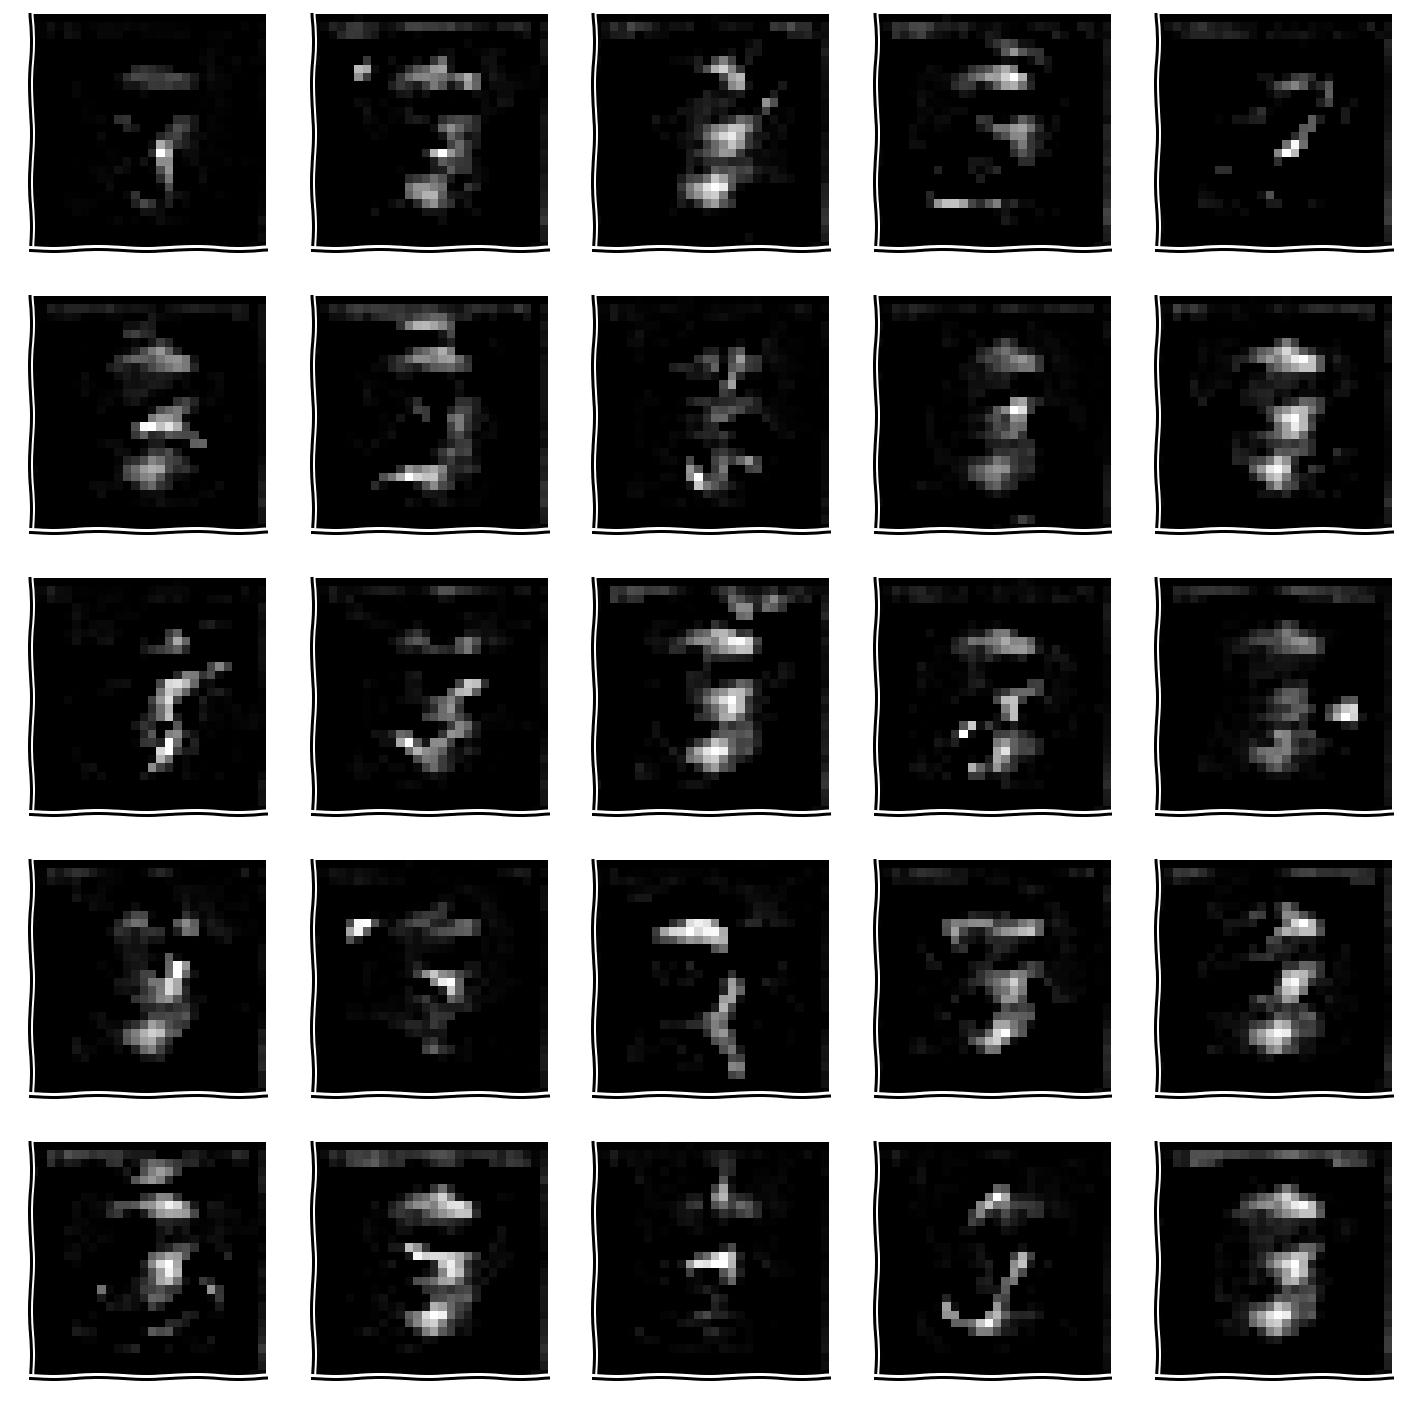

In [26]:
# to_remove solution
def generate_images(autoencoder, K, n_images=1):
  """Generate n_images 'new' images from the decoder part of the given
  autoencoder.

  returns (n_images, channels, height, width) tensor of images
  """
  # Concatenate tuples to get (n_images, channels, height, width)
  output_shape = (n_images,) + my_dataset_size
  with torch.no_grad():
    # sample z, pass through autoencoder.decode(), and reshape output.
    z = torch.randn(n_images, K)
    x = autoencoder.decode(z).reshape(output_shape)

    return x


# # Uncomment to run it
K = 20
set_seed(2021)
images = generate_images(conv_ae, K, n_images=25)
with plt.xkcd():
  plot_images(images)

## Formalizing the problem: density estimation with maximum likelihood


Note: we've moved the technical details of "formalizing the problem" to Appendix A.1 at the end of this notebook. Those who want more of the theoretical/mathematical backstory are encouraged to read it. Those who just want to build a VAE, carry on!

---
# Section 4: Variational Auto-Encoders (VAEs)

Video available at https://youtu.be/MKfeTzn_HaA


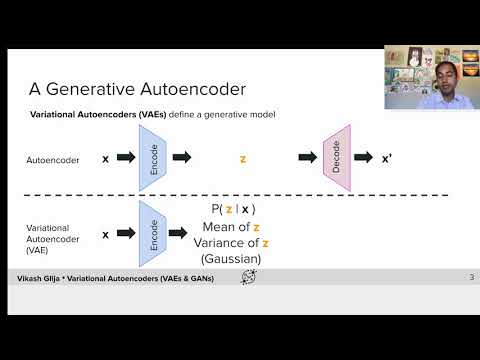

In [27]:
#@title Video 4: ariational Auto-Encoders (VAEs)
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="MKfeTzn_HaA", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

## Components of a VAE
## Recognition models and density networks

Variational AutoEncoders (VAEs) are a lot like the classic AutoEncoders (AEs) you just saw, but where we explicitly think about probability distributions. In the language of VAEs, the __encoder__ is replaced with a __recognition model__, and the __decoder__ is replaced with a __density network__.

Where in a classic autoencoder the encoder maps from images to a single hidden vector,
$$\mathbf{x} \overset{\text{AE}}{\longrightarrow} \mathbf{h} \, , $$ in a VAE we would say that a recognition model maps from inputs to entire __distributions__ over hidden vectors,
$$\mathbf{x} \overset{\text{VAE}}{\longrightarrow} q(\mathbf{z}) \, ,$$
which we will then sample from.
We'll say more in a moment about what kind of distribution $q(\mathbf{z})$ is.
Part of what makes VAEs work is that the loss function will require good reconstructions of the input not just for a single $\mathbf{z}$, but _on average_ from samples of $\mathbf{z} \sim q(\mathbf{z})$.

In the classic autoencoder, we had a decoder which maps from hidden vectors to reconstructions of the input:
$$\mathbf{h} \overset{\text{AE}}{\longrightarrow} \mathbf{x'} \, .$$
In a density network, reconstructions are expressed in terms of a distribution:
$$\mathbf{z} \overset{\text{VAE}}{\longrightarrow} p(\mathbf{x}|\mathbf{z};\mathbf{w}) $$
where, as above, $p(\mathbf{x}|\mathbf{z};\mathbf{w})$ is defined by mapping $\mathbf{z}$ through a density network then treating the resulting $f(\mathbf{z};\mathbf{w})$ as the mean of a (Gaussian) distribution over $\mathbf{x}$.

### Coding Exercise 4.1: sampling from $q(\mathbf{z})$

How can a neural network (the __recognition model__) output an entire probability distribution $$\mathbf{x} \longrightarrow q(\mathbf{z}) \, ?$$
One idea would be to make the weights of the neural network stochastic, so that every time the network is run, a different $\mathbf{z}$ is produced. (In fact, this is quite common in [Bayesian Neural Networks](https://medium.com/neuralspace/bayesian-neural-network-series-post-1-need-for-bayesian-networks-e209e66b70b2), but this isn't what people use in VAEs.)

Instead, we will start by committing to a particular _family_ of distributions. We'll then have the recognition model output the _parameters_ of $q$, which we'll call $\phi$. A common choice, which we will use throughout, is the family of isotropic multivariate Gaussians (spherical or isotropic: $\mathbf{\Sigma} = \sigma^2 ~ \mathbf{I}$) $^\dagger$:
$$q(\mathbf{z};\phi) = \mathcal{N}(\mathbf{z};\boldsymbol{\mu},\sigma^2\mathbf{I}_K) = \prod_{k=1}^K \mathcal{N}(z_k; \mu_k, \sigma^2)$$
where the $K+1$ parameters are$^*$
$$\phi = \lbrace{\mu_1, \mu_2, \ldots, \mu_K, \log(\sigma)}\rbrace \, .$$
By defining the last entry of $\phi$ as the _logarithm_ of $\sigma$, the last entry can be any real number while enforcing the requirement that $\sigma > 0$.

A recognition model is a neural network that takes $\mathbf{x}$ as input and produces $\phi$ as output. The purpose of the following exercise is not to write a recognition model (that will come later), but to clarify the relationship between $\phi$ and $q(\mathbf{z})$. You will write a function, `rsample`, which takes as input a batch $\phi$s and will output a set of samples of $\mathbf{z}$ drawn from $q(\mathbf{z};\phi)$.

In [28]:
def rsample(phi, n_samples):
  """Sample z ~ q(z;phi)
  Ouput z is size [b, n_samples, K] given phi with shape [b,K+1]. The first K
  entries of each row of phi are the mean of q, and phi[:,-1] is the log
  standard deviation
  """
  b, kplus1 = phi.size()
  k = kplus1 - 1
  mu, sig = phi[:, :-1], phi[:, -1].exp()
  ####################################################################
  # Fill in all missing code below (...),
  # then remove or comment the line below to test your function
  raise NotImplementedError("Please complete the rsample function!")
  ####################################################################
  eps = ...
  return eps * sig.view(b, 1, 1) + mu.view(b, 1, k)


# # Uncomment below to test your code
# phi = torch.randn(4, 3, device=DEVICE)
# set_seed(2021)
# zs = rsample(phi, 100)
# assert zs.size() == (4, 100, 2), "rsample size is incorrect!"
# assert zs.device == phi.device, "rsample device doesn't match phi device!"
# zs = zs.cpu()
# plot_phi(phi)

Seed 2021 has been set.


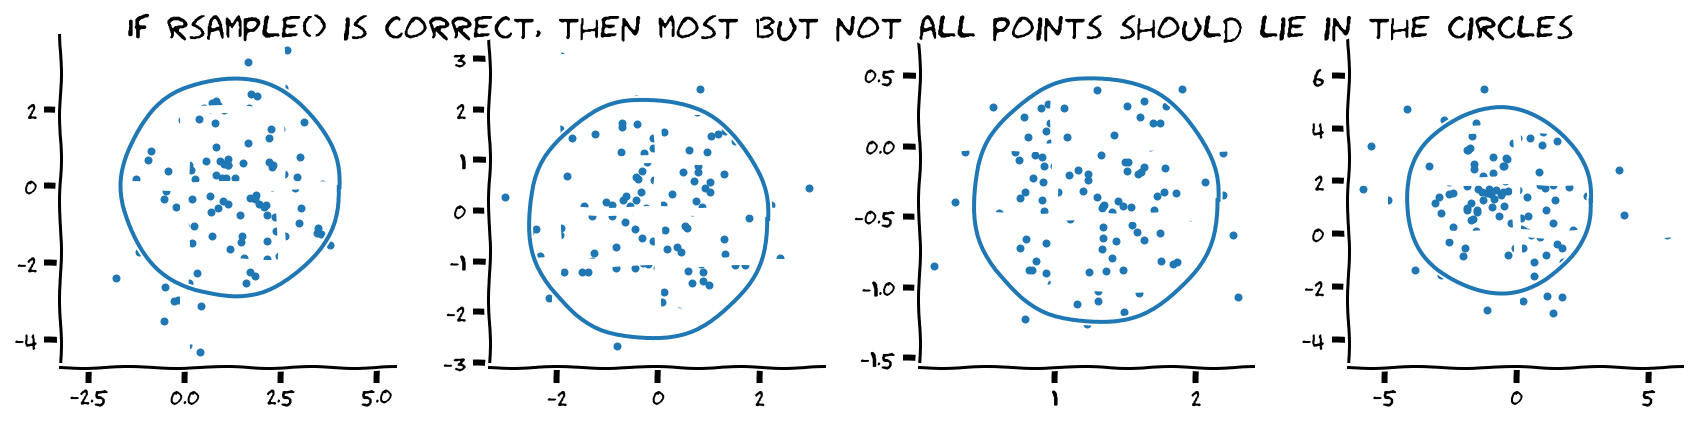

In [29]:
# to_remove solution
def rsample(phi, n_samples):
  """Sample z ~ q(z;phi)
  Ouput z is size [b,n_samples,K] given phi with shape [b,K+1]. The first K
  entries of each row of phi are the mean of q, and phi[:,-1] is the log
  standard deviation
  """
  b, kplus1 = phi.size()
  k = kplus1 - 1
  mu, sig = phi[:, :-1], phi[:, -1].exp()
  eps = torch.randn(b, n_samples, k, device=phi.device)
  return eps * sig.view(b, 1, 1) + mu.view(b, 1, k)


# # Uncomment below to test your code
phi = torch.randn(4, 3, device=DEVICE)
set_seed(2021)
zs = rsample(phi, 100)
assert zs.size() == (4, 100, 2), "rsample size is incorrect!"
assert zs.device == phi.device, "rsample device doesn't match phi device!"
zs = zs.cpu()
with plt.xkcd():
  plot_phi(phi)

$^\dagger$ PyTorch has a `MultivariateNormal` class which handles multivariate Gaussian distributions with arbitrary covariance matrices. It is not very beginner-friendly, though, so we will write our own functions to work with $\phi$, which will both teach you some implementation details and is not very hard especially if we use only an isotropic ($\sigma$) or diagonal ($\lbrace{\sigma_1, \ldots, \sigma_K}\rbrace$) covariance

$^*$ Another common parameterization is to use a separate $\sigma$ for each dimension of $\mathbf{z}$, in which case $\phi$ would instead contain $2K$ parameters:
$$\phi = \lbrace{\mu_1, \mu_2, \ldots, \mu_K, \log(\sigma_1), \ldots, \log(\sigma_K)}\rbrace \, .$$

---
# Section 5: State of the art VAEs and Wrap-up

Video available at https://youtube.com/watch?v=f2jSzq7lndo


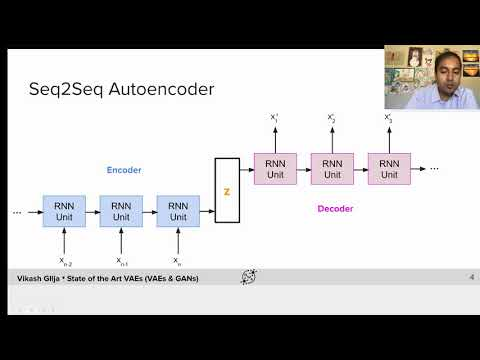

In [30]:
#@title Video: State-of-the-art VAEs

video = YouTubeVideo(id="f2jSzq7lndo", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video